#### MemorySaver
LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update.

One of the easiest checkpointers to use is the MemorySaver, an in-memory key-value store for Graph state.

All we need to do is simply compile the graph with a checkpointer, and our graph has memory!

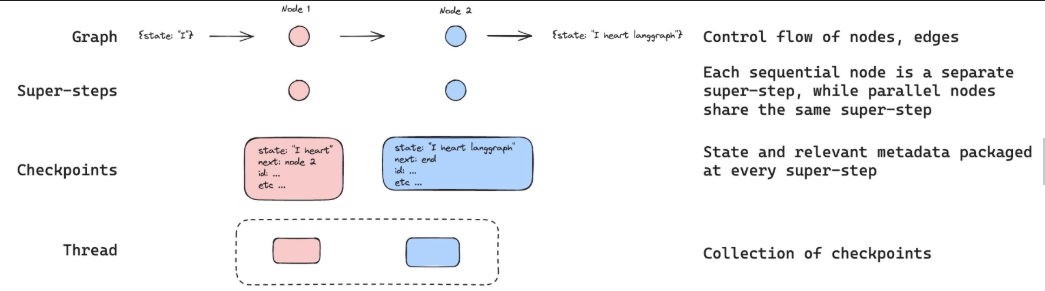

In [2]:
from dotenv import load_dotenv
import os
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [20]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper

api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2,doc_content_chars=500)

arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)

api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=2,doc_content_chars=500)

wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)

def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

tools = [arxiv,wiki,add]

In [21]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="llama-3.1-8b-instant")
llm_with_tools = llm.bind_tools(tools)

In [22]:
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode,tools_condition
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage,HumanMessage

class State(TypedDict):
    messages : Annotated[list[AnyMessage],add_messages]

def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

graph = StateGraph(State)

graph.add_node("tool_calling_llm",tool_calling_llm)
graph.add_node("tools",ToolNode(tools))

graph.add_edge(START,"tool_calling_llm")
graph.add_conditional_edges("tool_calling_llm",tools_condition)
graph.add_edge("tools","tool_calling_llm")

###### define and add memory to the graph

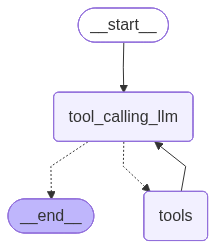

In [23]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
graph_memory = graph.compile(checkpointer=memory)

display(Image(graph_memory.get_graph().draw_mermaid_png()))

###### Specify the thread - unique to each user

In [24]:
config = {"configurable":{"thread_id":"1"}}

messages = [HumanMessage(content="Add 12 and 13.")]

messages = graph_memory.invoke({"messages":messages},config=config)

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================
Tool Calls:
  add (hp2dsg41a)
 Call ID: hp2dsg41a
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The result of adding 12 and 13 is 25.


In [27]:
messages = [HumanMessage(content="Divide that by 5")]
messages = graph_memory.invoke({"messages":messages},config=config)

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================
Tool Calls:
  add (hp2dsg41a)
 Call ID: hp2dsg41a
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The result of adding 12 and 13 is 25.
================================ Human Message =================================

Divide that by 5
================================== Ai Message ==================================
Tool Calls:
  add (nah9m55cc)
 Call ID: nah9m55cc
  Args:
    a: 25
    b: -5
================================= Tool Message =================================
Name: add

20
================================== Ai Message ==================================

The result of dividing 25 by 5 is 5.


In [28]:
messages = [HumanMessage(content="then multiply by 2")]
messages = graph_memory.invoke({"messages":messages},config=config)

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================
Tool Calls:
  add (hp2dsg41a)
 Call ID: hp2dsg41a
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The result of adding 12 and 13 is 25.
================================ Human Message =================================

Divide that by 5
================================== Ai Message ==================================
Tool Calls:
  add (nah9m55cc)
 Call ID: nah9m55cc
  Args:
    a: 25
    b: -5
================================= Tool Message =================================
Name: add

20
================================== Ai Message ==================================

The result of dividing 25 by 5 is 5.
================================ Human Message ==========